# Table of Contents

[Question 1](#one) [Question 2](#two)  
[Reinvestigating Anomaly](#Giant-Anomaly)

In [2]:
import pandas as pd
import numpy as np


#visualizations libraries
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

plt.style.use('bmh')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

#machine learning libraries
import xgboost as xgb
import catboost as cb 
from sklearn.metrics import mean_squared_error

from matplotlib import patheffects
import statsmodels.api as sm

import os

#project modules
import src.wrangle as wr
import src.summaries as su
import src.explore as ex

%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from importlib import reload

import warnings
warnings.filterwarnings('ignore')

# one

-[return to TOC](#Table-of-Contents)

- We know that the covid-19 global pandemic altered business in the United States among countries of the world. Certainly Cisco Systems' sales in the state of Texas would be effected somehow. I set out to see if there would be large anamolous activities around the year 2020. First, I found that there is an enormous jump in quantities of orders from customers. This jump occured on Janurary 2, 2020. Texas Health and Human Services Commission purchased 3,767,123 units of something and 865,822 unites of something else. What were the things purchased? We cannot say from this data but considering the first order had a price of  0.00186 𝑝𝑒𝑟 𝑢𝑛𝑖𝑡 𝑎𝑛𝑑 0.00085 per unit, we speculate that it might be licenses for cisco connect, Cisco System's VPN service.

- We found that a large purchase order like this is made for Texas Health and Human Services periodically, but the purchase is limited to around 1 million somethings. This purchase probably had to do with foresight regarding what could come given the brewing pandemic which was being reported in China.

- You may follow the following graphs to see the findings

In [64]:
def clean_df():
    df = wr.get_clean_data(start2018=True)
    df = df.drop(columns = ['shipped_date', 'order_date_copy'])
    df['purchase_amount'] = df['purchase_amount'].astype('int64')
    df['customer_zip'] = df['customer_zip'].astype('int8')
    df['order_quantity'] = df['order_quantity'].astype('int64')
    df['unit_price'] = df['unit_price'].astype('float64')
    
    return df

In [65]:
df = clean_df()

### Notice the large order quantity outlier

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261886 entries, 2018-01-02 to 2022-11-29
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_name    261886 non-null  object 
 1   customer_type    261886 non-null  object 
 2   customer_city    261886 non-null  object 
 3   reseller_name    261886 non-null  object 
 4   reseller_city    261403 non-null  object 
 5   customer_zip     261886 non-null  int8   
 6   order_quantity   261886 non-null  int64  
 7   unit_price       261886 non-null  float64
 8   po_number        261883 non-null  object 
 9   year             261886 non-null  int64  
 10  quarter          261886 non-null  int64  
 11  month_name       261886 non-null  object 
 12  day_name         261886 non-null  object 
 13  month            261886 non-null  int64  
 14  week             261886 non-null  int64  
 15  day_of_week      261886 non-null  int64  
 16  day_of_year      26188

<AxesSubplot:xlabel='Purchase Amount'>

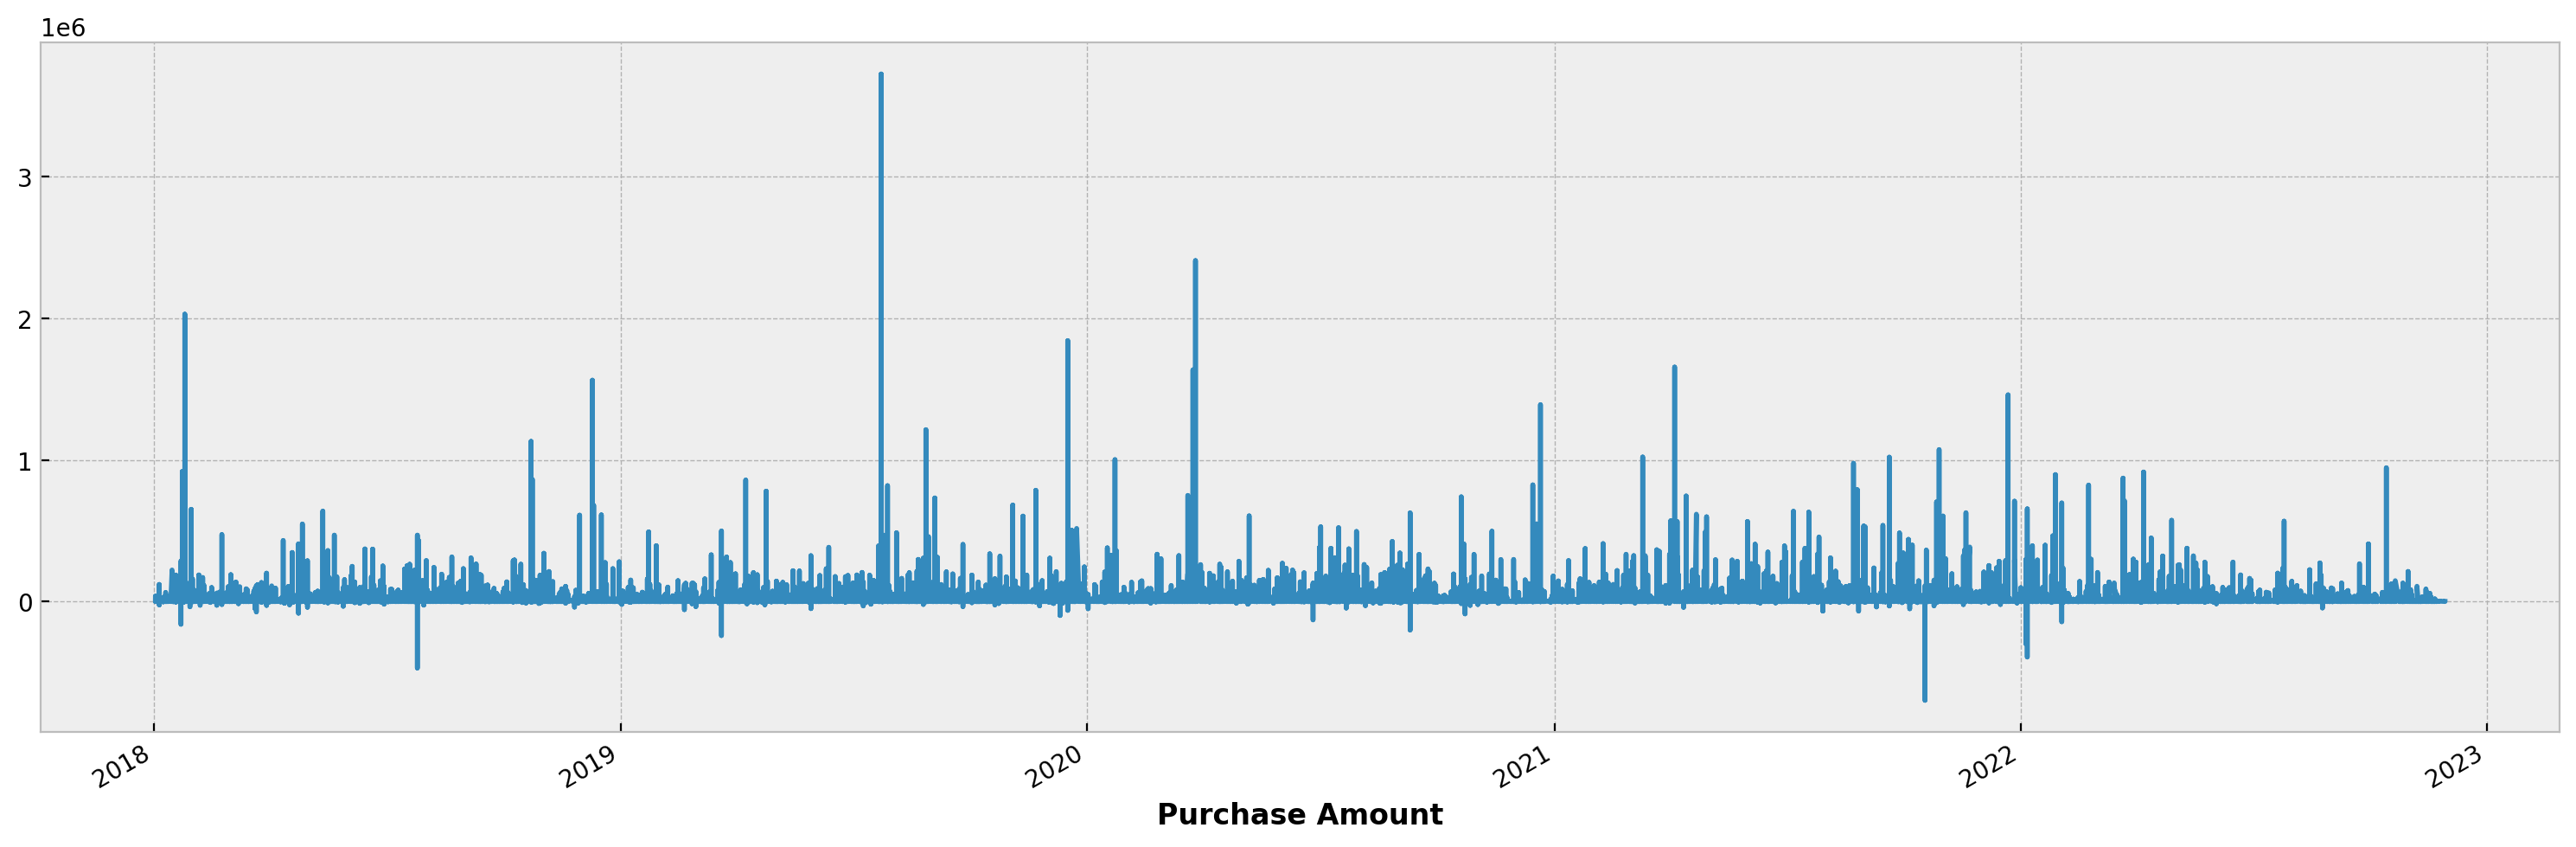

In [6]:
fix, ax = plt.subplots(figsize = (15,5))
df['purchase_amount'].plot(ax=ax, xlabel='Purchase Amount')

<AxesSubplot:xlabel='Order Quantity'>

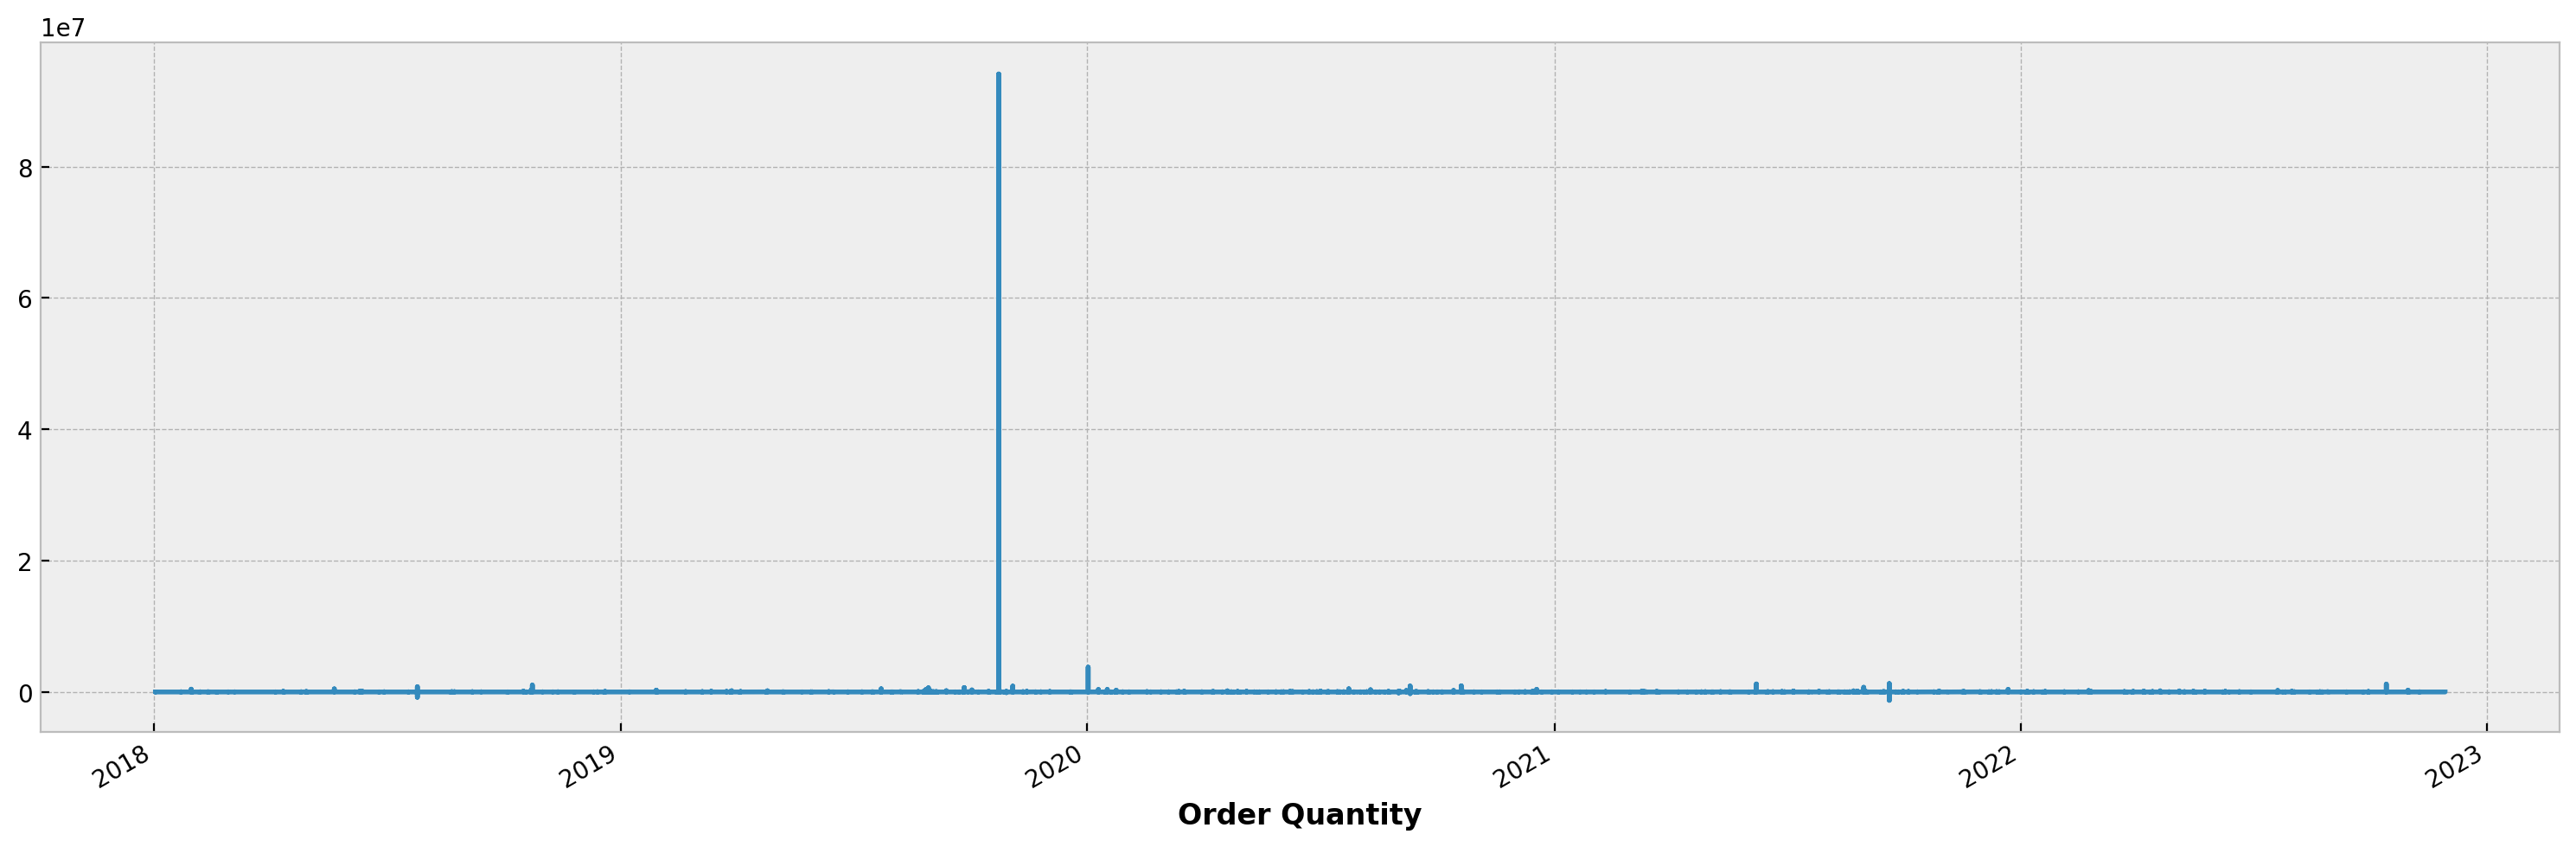

In [18]:
fix, ax = plt.subplots(figsize = (15,5))
df['order_quantity'].plot(ax=ax, xlabel='Order Quantity')

### Isolating the pandemic year

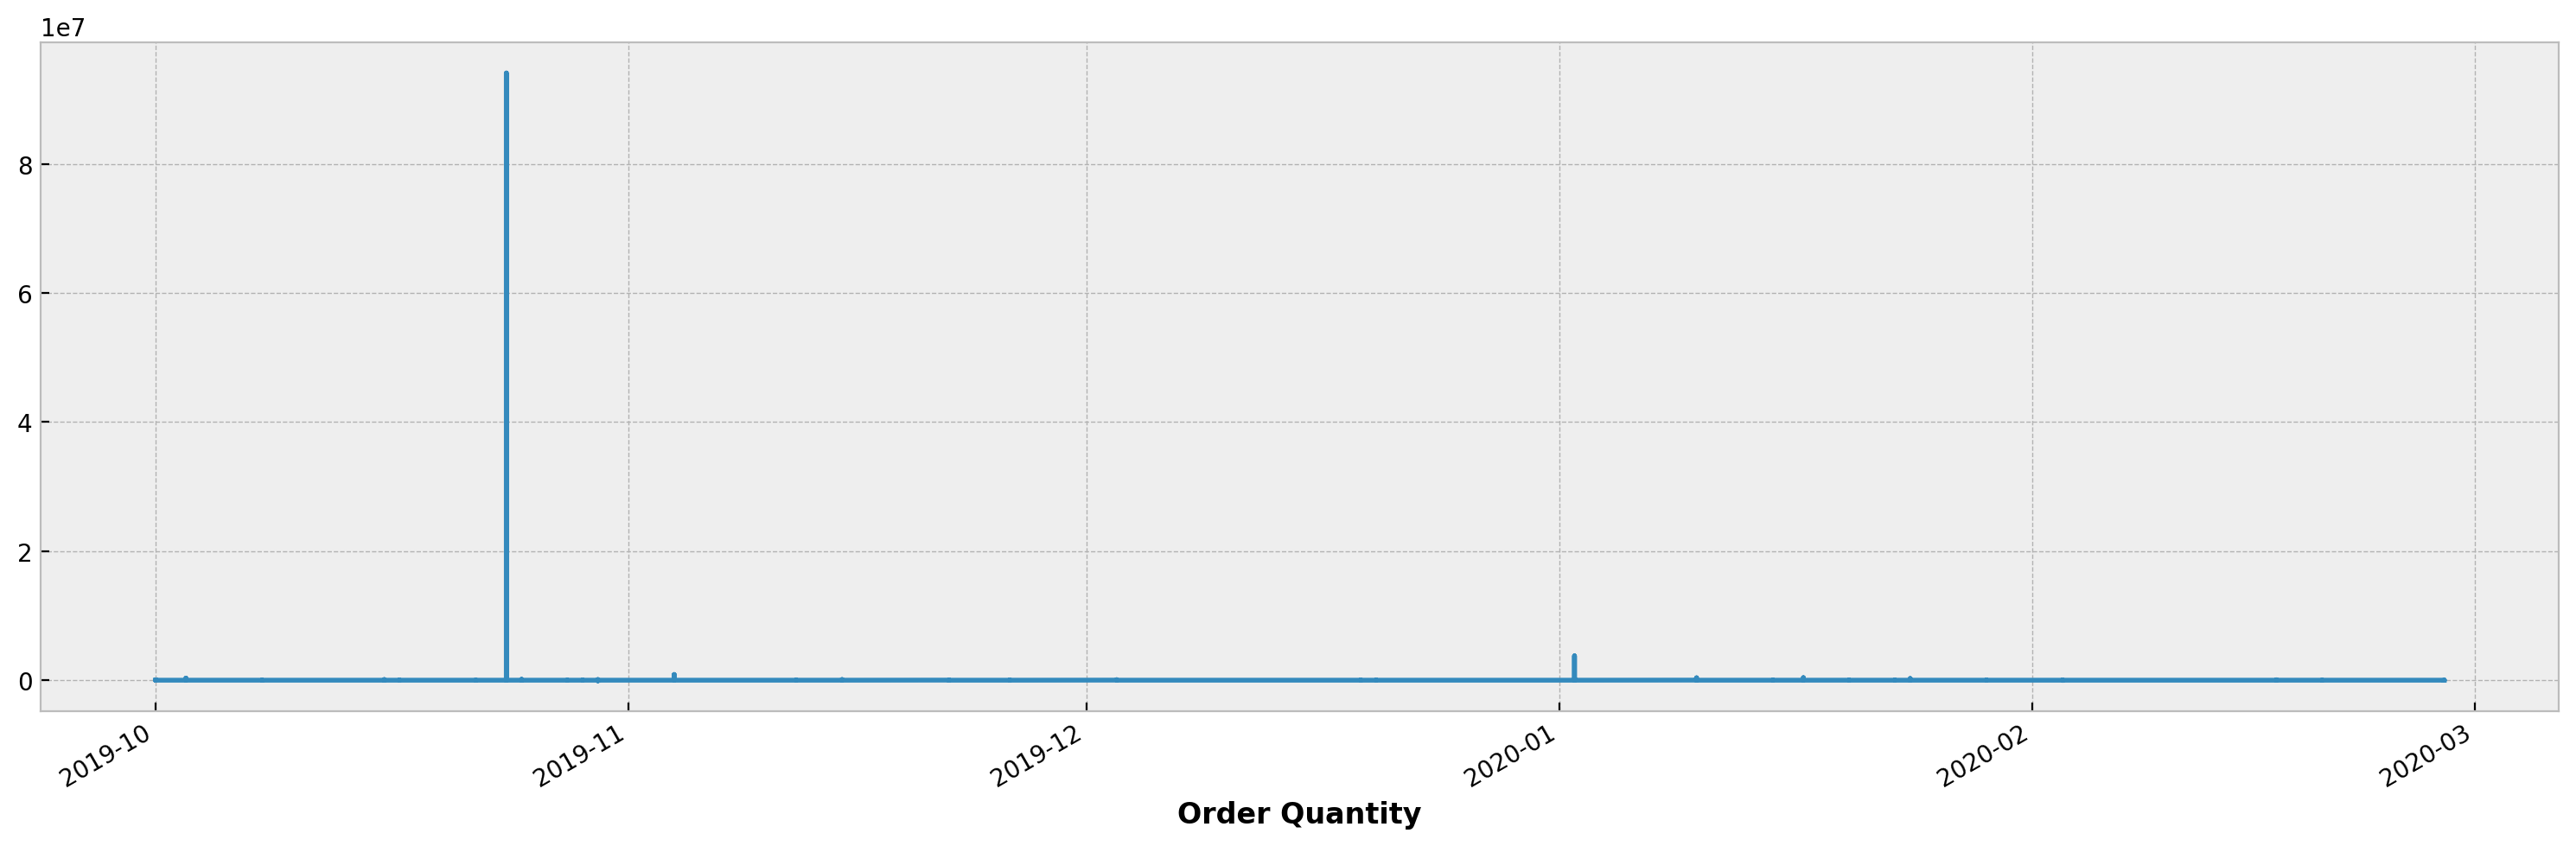

In [10]:
pandemic_df = df.loc[df.index >= '10-01-2019']
pandemic_df = pandemic_df.loc[pandemic_df.index < '03-01-2020']


fix, ax = plt.subplots(figsize = (15,5))
#ax = pandemic_df.plot(x_compat=True)-
pandemic_df['order_quantity'].plot(ax=ax, xlabel='Order Quantity')
plt.show()

### Taking a peek at who the big buyers were on that anomolous day

<BarContainer object of 6 artists>

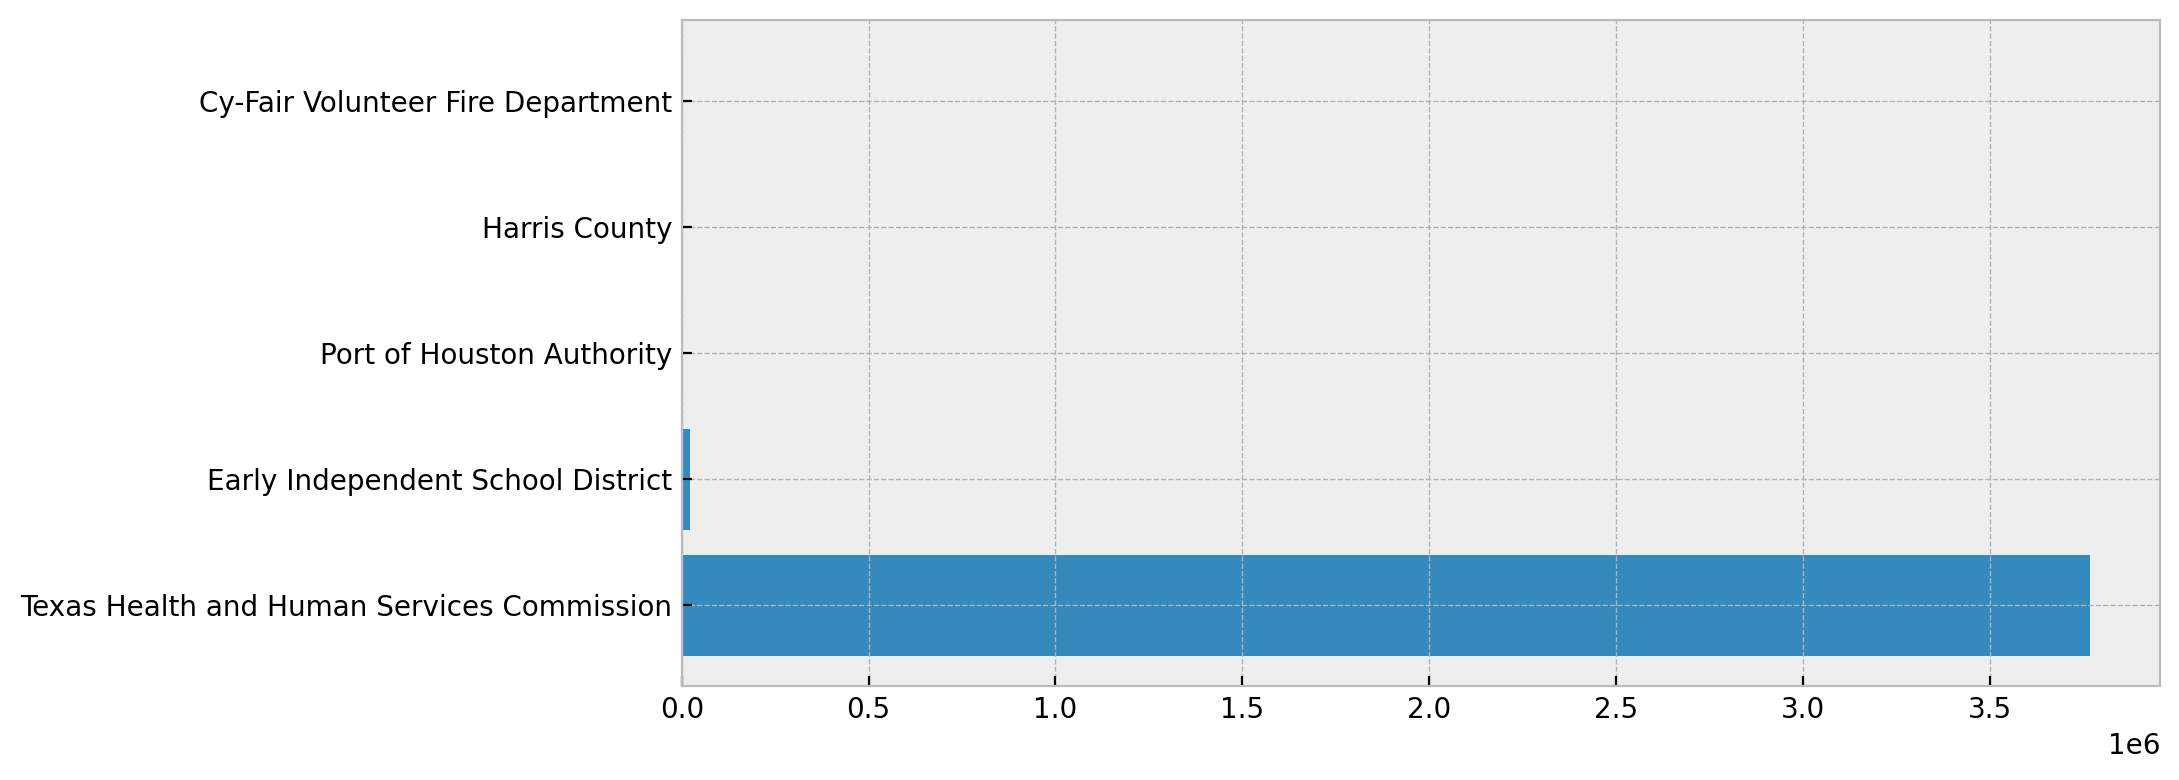

In [44]:
jan2 = pandemic_df.loc[pandemic_df.index == '01-02-2020']
jan2purchases = jan2.sort_values(by=['order_quantity'], ascending = False).head(6)
fig, ax = plt.subplots()
ax.barh(jan2purchases.customer_name, jan2purchases.order_quantity)

## We can see that Texas Health and Human Services Commission purchased close to 4 million somethings from Cisco Systems one time, outside of any predictable pattern

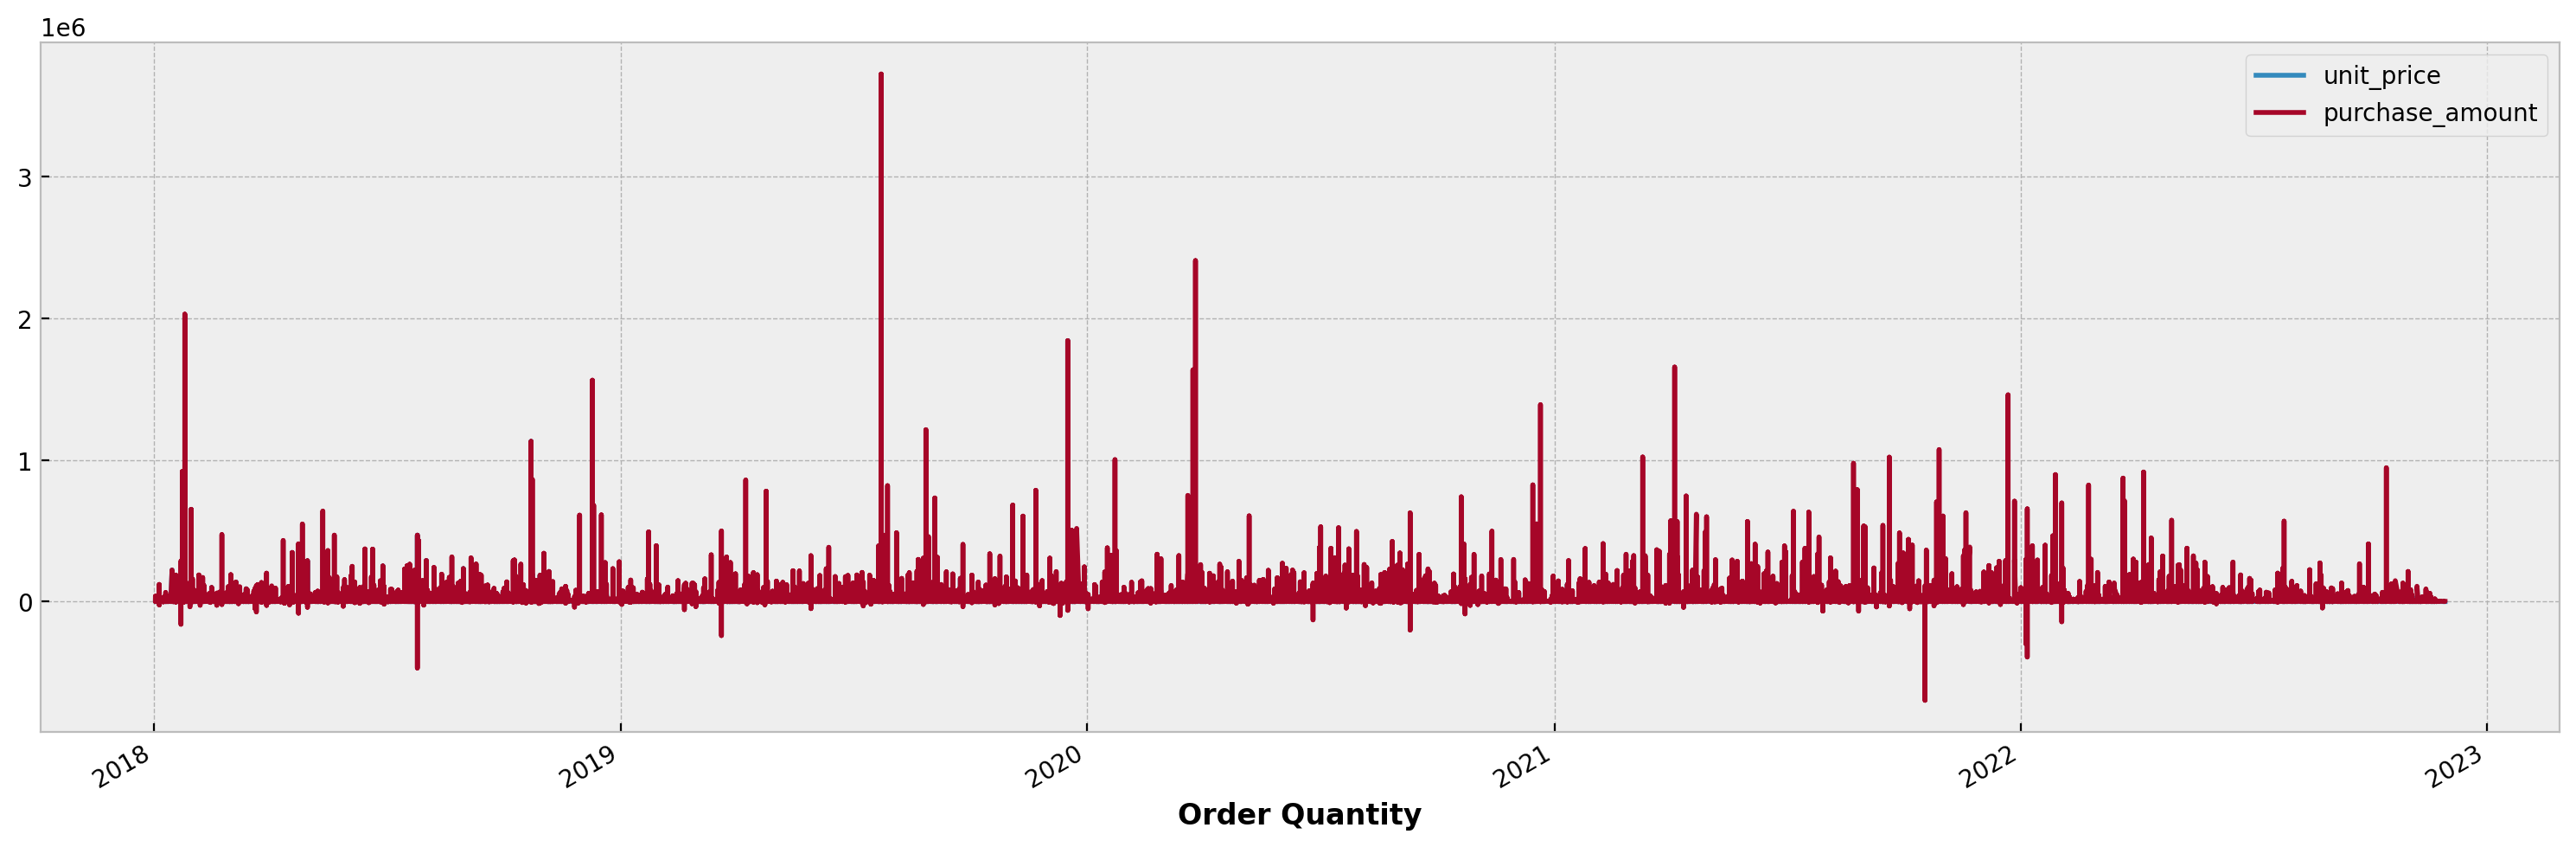

In [40]:
pandemic_df = df.loc[df.index >= '11-01-2019']
pandemic_df = pandemic_df.loc[pandemic_df.index < '01-01-2021']
#pandemic_df = df.drop(columns = ['order_quantity', 'customer_zip', 'year', 'quarter', 'month', 'week', 'day_of_week', 'day_of_year'])

fix, ax = plt.subplots(figsize = (15,5))
#ax = pandemic_df.plot(x_compat=True)-
pandemic_df.plot(ax=ax, xlabel='Order Quantity')
plt.show()

<AxesSubplot:xlabel='Unit Price'>

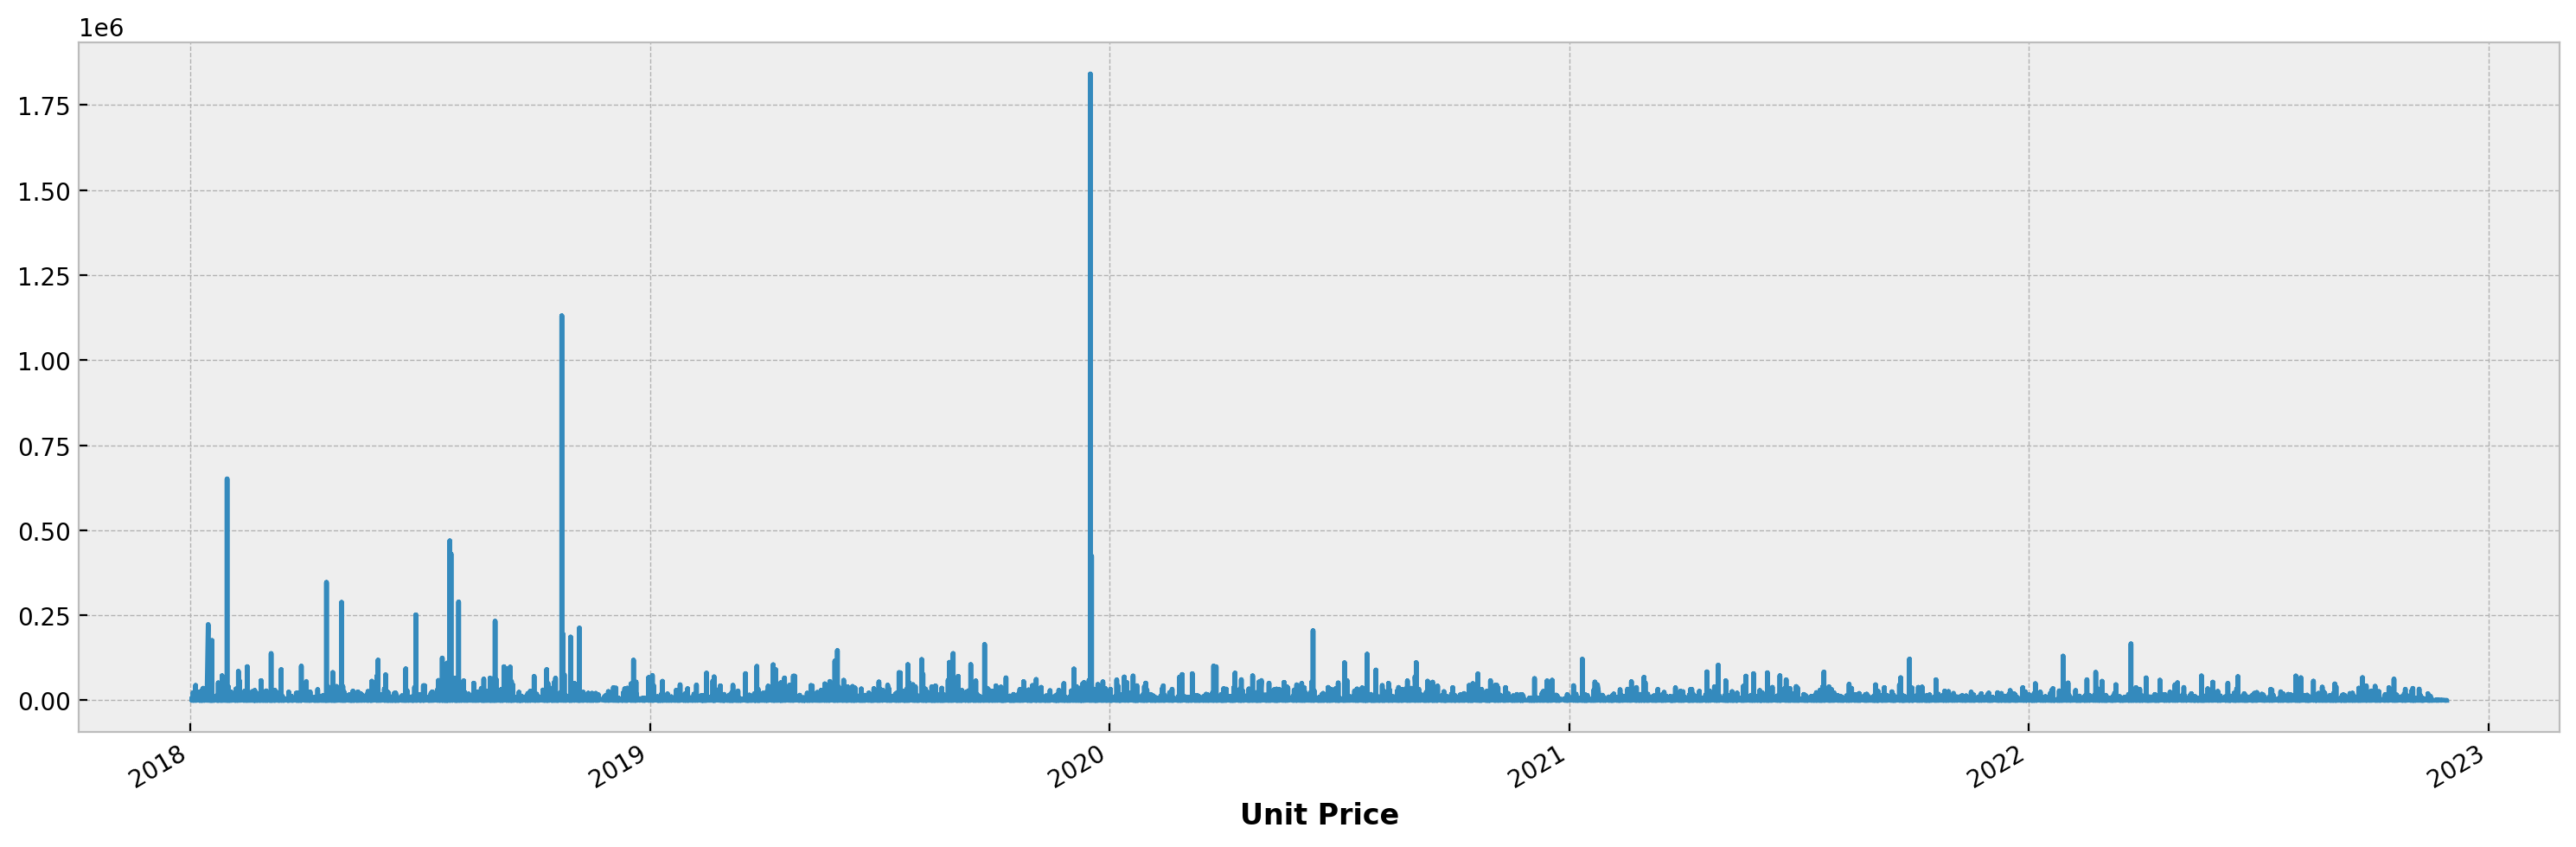

In [11]:
fix, ax = plt.subplots(figsize = (15,5))
df['unit_price'].plot(ax=ax, xlabel='Unit Price')

# two

-[return to TOC](#Table-of-Contents)

- It seems that Cisco Systems' revenue model is one which is based around two types of products. One product is purchased annually, for a small price, and in potentially large quantities.The second type of product is purchased less regularly, in smaller quantities, and for larger prices
- If this is the case, then predicting sales revenues from Texas' agency purchases will require two models. One which predicts the first kind of product, the other which predicts the second kind of product. I will attempt to demonstrate these two kinds of product patterns

In [49]:
df = wr.get_clean_data(start2018=True)
train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

### Note that the full dataset appears to have a lot of noise before it is modified

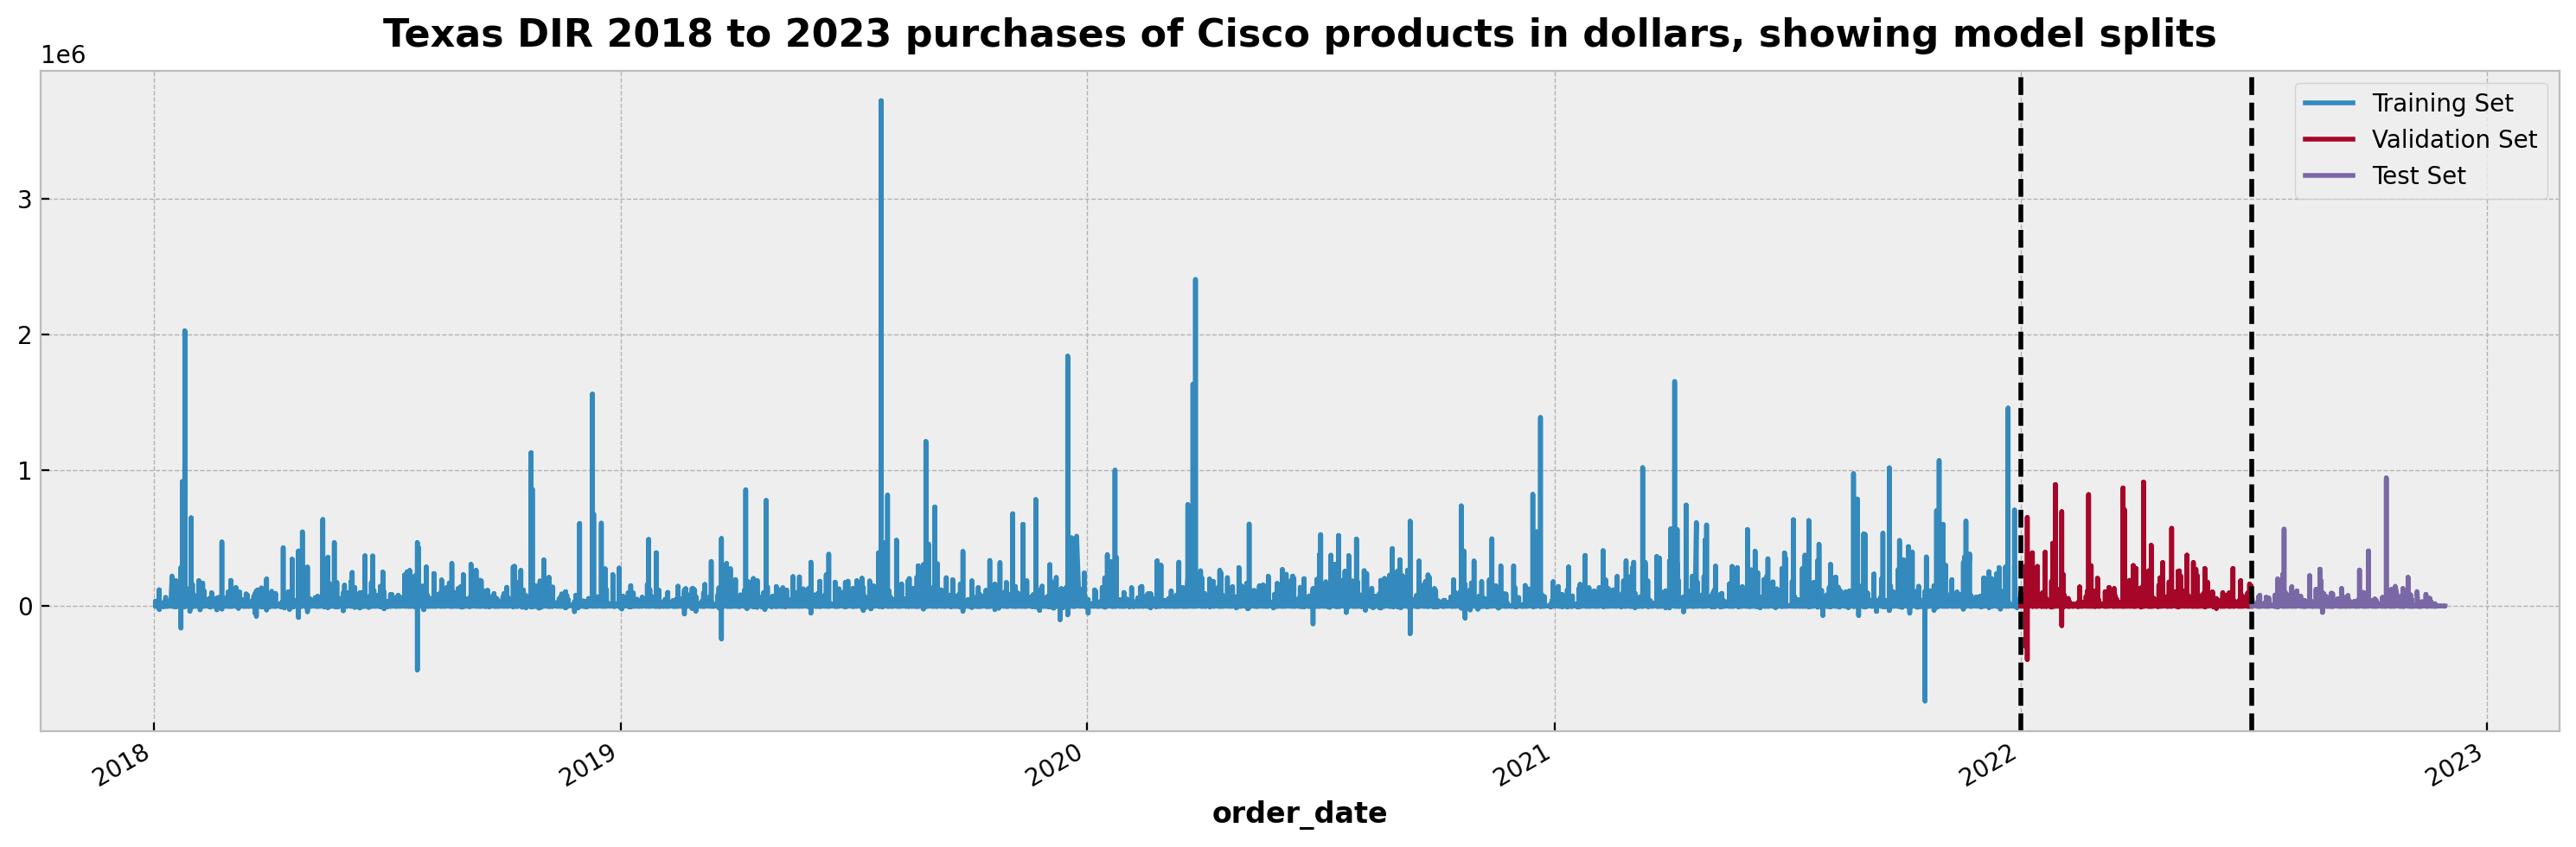

In [60]:
fix, ax = plt.subplots(figsize = (15,5))
train['purchase_amount'].plot(ax = ax, label='Training Set', title='Texas DIR 2018 to 2023 purchases of Cisco products in dollars, showing model splits')
validate['purchase_amount'].plot(ax = ax, label='Validation Set')
test['purchase_amount'].plot(ax = ax, label='Test Set')
ax.axvline('01-01-22', color='black', ls='--')
ax.axvline('07-01-22', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])
plt.show()

### Splitting between purchases of goods which are over \\$5 per unit and goods which are less than \\$5 per unit

In [52]:
df = clean_df()
n = 5
df_large_price = df[df['unit_price'] > n]
df_small_price = df[df['unit_price'] <= n]

lp_train, lp_test = wr.split_data(df_large_price, explore=True)
lp_validate = lp_test.loc[:'2022-06'].copy() 
lp_test = lp_test.loc['2022-07':]

sp_train, sp_test = wr.split_data(df_small_price, explore=True)
sp_validate = sp_test.loc[:'2022-06'].copy() 
sp_test = sp_test.loc['2022-07':]

### Viewing data over our time period for purchases over \\$5

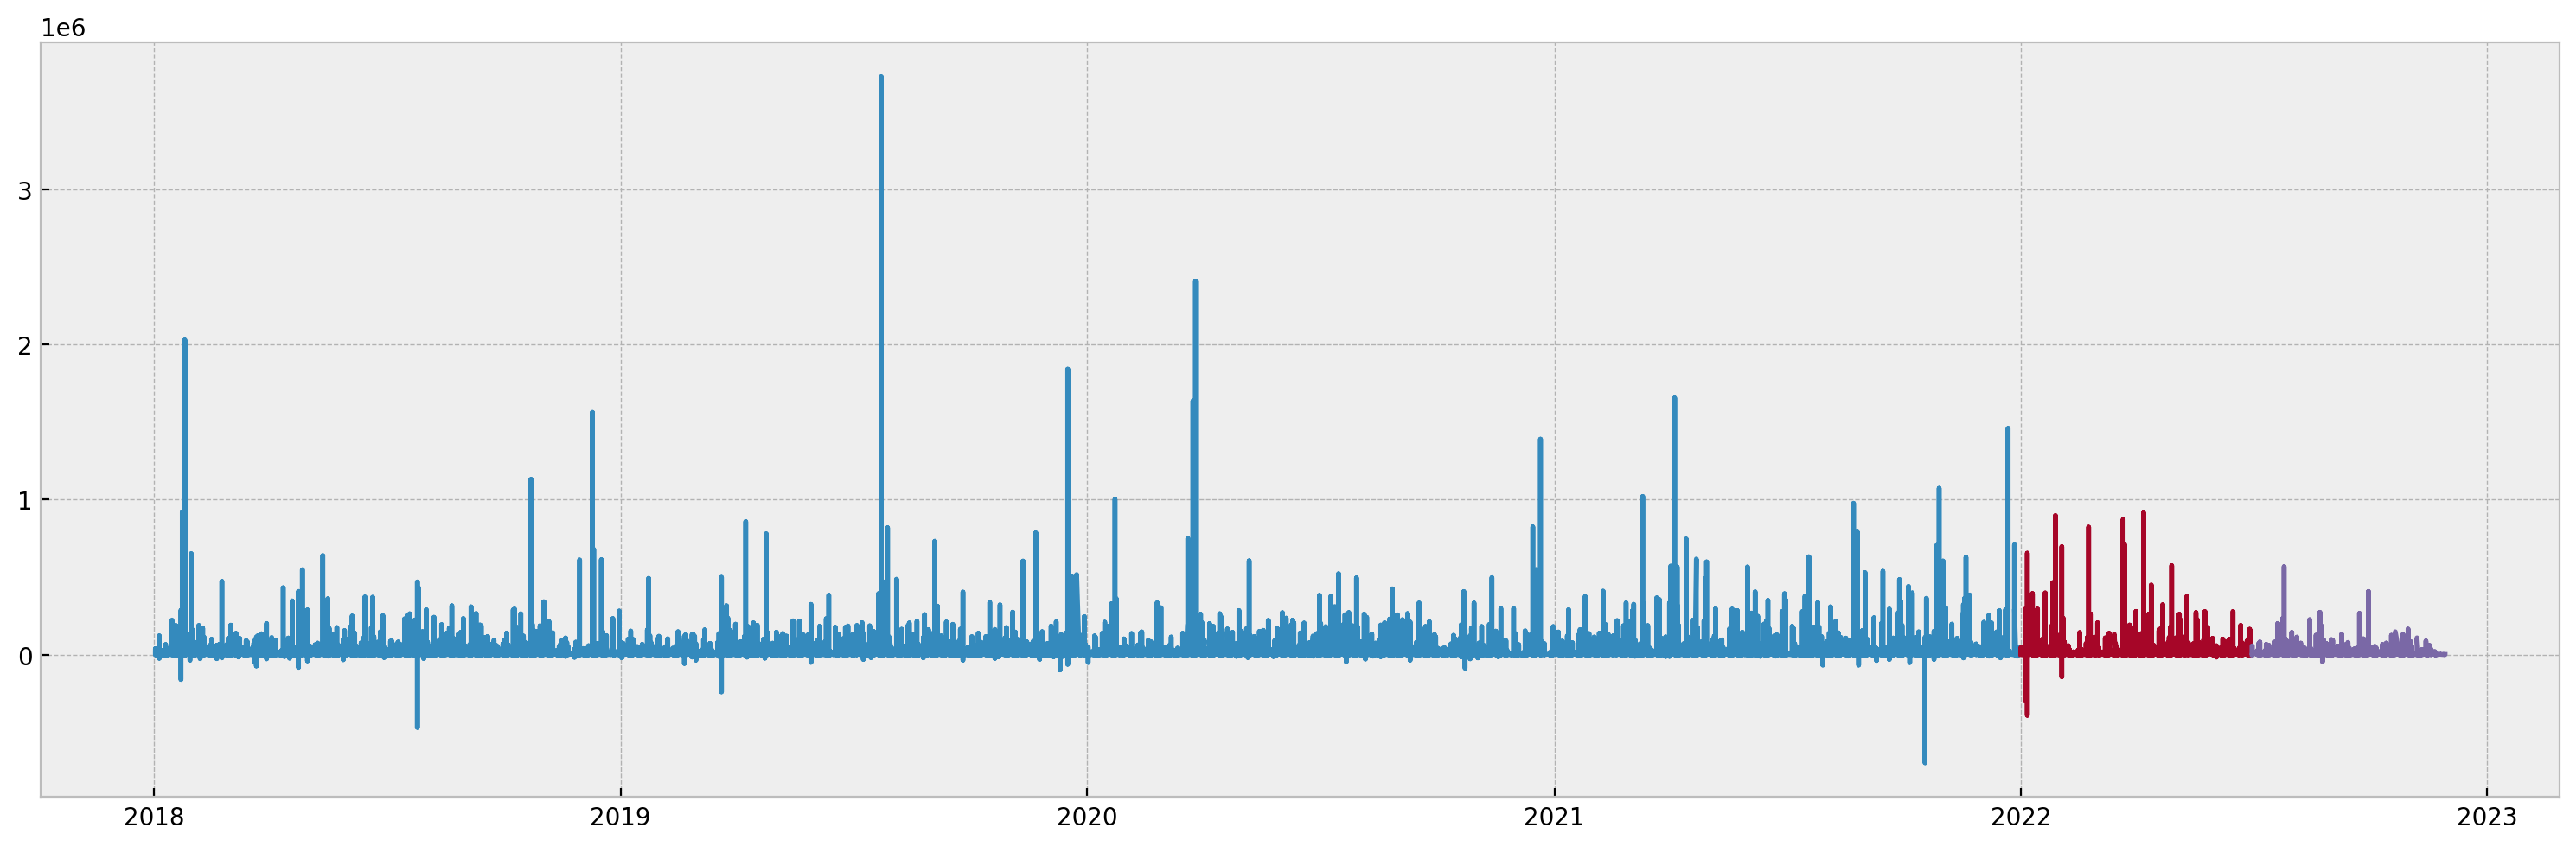

In [53]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(lp_train.index, lp_train['purchase_amount'])
plt.plot(lp_validate.index, lp_validate['purchase_amount'])
plt.plot(lp_test.index, lp_test['purchase_amount'])

### Viewing data over our time period for purchases under \\$5

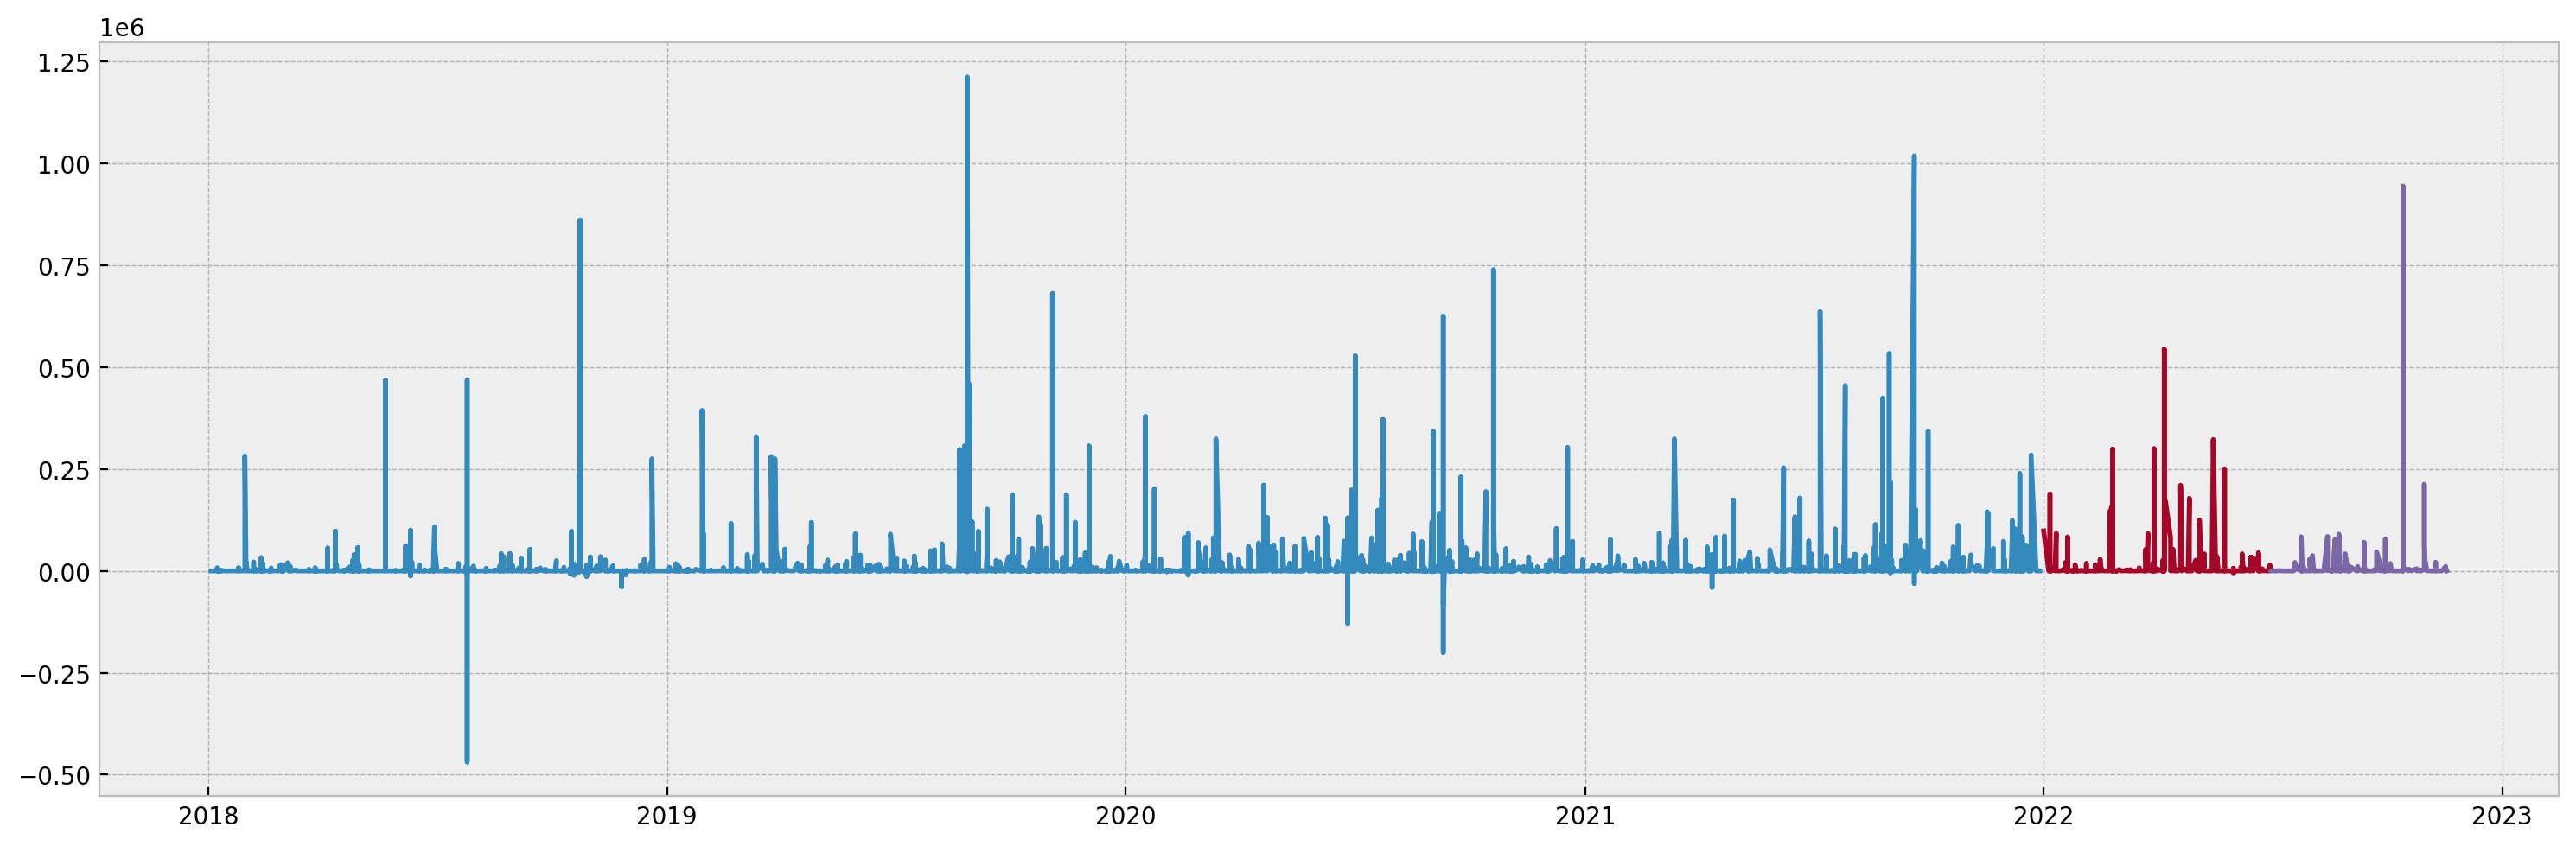

In [54]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(sp_train.index, sp_train['purchase_amount'])
plt.plot(sp_validate.index, sp_validate['purchase_amount'])
plt.plot(sp_test.index, sp_test['purchase_amount'])

### In the second group, we see something that appears more patterned. The first group appears very noisy. Breaking our model upon those lines might make cisco purchases more predictable

## Reinvestigating our giant anomaly

#### Giant Anomaly
[return to TOC](#Table-of-Contents)

In [66]:
df[df.po_number == '21200 212200158']

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,1,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,24,120.91670,21200 212200158,2019,4,October,Thursday,10,43,3,297,2902
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,94093187,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,1,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,1,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,1,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,10,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0


In [28]:
df[df.index == '10-24-2019'].sort_values(by=['order_quantity'], ascending = False)

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,94093187,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0
2019-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,500000,0.11000,HHSTX-0-209325,2019,4,October,Thursday,10,43,3,297,55000
2019-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,183751,0.72000,HHSTX-0-209325,2019,4,October,Thursday,10,43,3,297,132301
2019-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,152777,0.36000,HHSTX-0-209325,2019,4,October,Thursday,10,43,3,297,55000
2019-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,30126,0.80000,HHSTX-0-209325,2019,4,October,Thursday,10,43,3,297,24101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-24,Texas Parks and Wildlife Department,State Agency,Austin,Great South Texas Corporation dba Computer Sol...,San Antonio,-104,-1,42.56000,9532000073,2019,4,October,Thursday,10,43,3,297,-42
2019-10-24,Texas Parks and Wildlife Department,State Agency,Austin,Great South Texas Corporation dba Computer Sol...,San Antonio,-104,-2,492.80000,9532000073,2019,4,October,Thursday,10,43,3,297,-985
2019-10-24,Georgetown Independent School District,K-12,Georgetown,CDW Government LLC,Vernon Hills,36,-4,734.40000,RMA 009973874 A 9052000166,2019,4,October,Thursday,10,43,3,297,-2937


In [30]:
df.sort_values(by=['order_quantity'], ascending = False).head(10)

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,94093187,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0
2020-01-02,Texas Health and Human Services Commission,State Agency,Austin,"Netsync Network Solutions, Inc.",Houston,119,3767123,0.00186,HHSTX-0-0000202893,2020,1,January,Thursday,1,1,3,2,7010
2021-09-20,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,1273855,0.80000,HHSTX-2-271718,2021,3,September,Monday,9,38,0,263,1019084
2021-06-08,Texas A&M University,Higher Ed,College Station,"Netsync Network Solutions, Inc.",Houston,19,1216118,0.08800,AB0631328,2021,2,June,Tuesday,6,23,1,159,107018
2022-10-14,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,1195487,0.79000,HHSTX-3-302677,2022,4,October,Friday,10,41,4,287,944435
2021-06-08,Texas A&M University System,Higher Ed,College Station,"Netsync Network Solutions, Inc.",Houston,19,1142400,0.20168,AB0631328,2021,2,June,Tuesday,6,23,1,159,230400
2018-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,1048103,0.82190,1100629171,2018,4,October,Wednesday,10,43,2,297,861436
2020-10-20,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,935578,0.79000,HHSTX-1-245224,2020,4,October,Tuesday,10,43,1,294,739107
2020-09-10,Tarrant County College,Higher Ed,Fort Worth,"SHI Government Solutions, Inc.",Austin,70,900000,0.69528,S081747,2020,3,September,Thursday,9,37,3,254,625750


In [31]:
#df.drop(df[df['order_quantity'] > 94_000_000])
df[df['order_quantity'] > 94_000_000]

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,
2019-10-24,Office of Court Administration,State Agency,Austin,"SHI Government Solutions, Inc.",Austin,119,94093187,0.00000,21200 212200158,2019,4,October,Thursday,10,43,3,297,0


In [41]:
df = df.drop(df[df['order_quantity'] > 94_000_000].index )

In [42]:
df[df['order_quantity'] > 94_000_000]

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,


In [44]:
df.sort_values(by=['order_quantity'], ascending = False).head(10)

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,
2020-01-02,Texas Health and Human Services Commission,State Agency,Austin,"Netsync Network Solutions, Inc.",Houston,119,3767123,0.00186,HHSTX-0-0000202893,2020,1,January,Thursday,1,1,3,2,7010
2021-09-20,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,1273855,0.80000,HHSTX-2-271718,2021,3,September,Monday,9,38,0,263,1019084
2021-06-08,Texas A&M University,Higher Ed,College Station,"Netsync Network Solutions, Inc.",Houston,19,1216118,0.08800,AB0631328,2021,2,June,Tuesday,6,23,1,159,107018
2022-10-14,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,1195487,0.79000,HHSTX-3-302677,2022,4,October,Friday,10,41,4,287,944435
2021-06-08,Texas A&M University System,Higher Ed,College Station,"Netsync Network Solutions, Inc.",Houston,19,1142400,0.20168,AB0631328,2021,2,June,Tuesday,6,23,1,159,230400
2018-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,1048103,0.82190,1100629171,2018,4,October,Wednesday,10,43,2,297,861436
2020-10-20,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,935578,0.79000,HHSTX-1-245224,2020,4,October,Tuesday,10,43,1,294,739107
2020-09-10,Tarrant County College,Higher Ed,Fort Worth,"SHI Government Solutions, Inc.",Austin,70,900000,0.69528,S081747,2020,3,September,Thursday,9,37,3,254,625750
2019-11-04,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,119,884747,0.77000,HHSTX-0-209325,2019,4,November,Monday,11,45,0,308,681255


[Text(0.5, 1.0, 'Quantity of Cisco Products purchased by Texas DIR')]

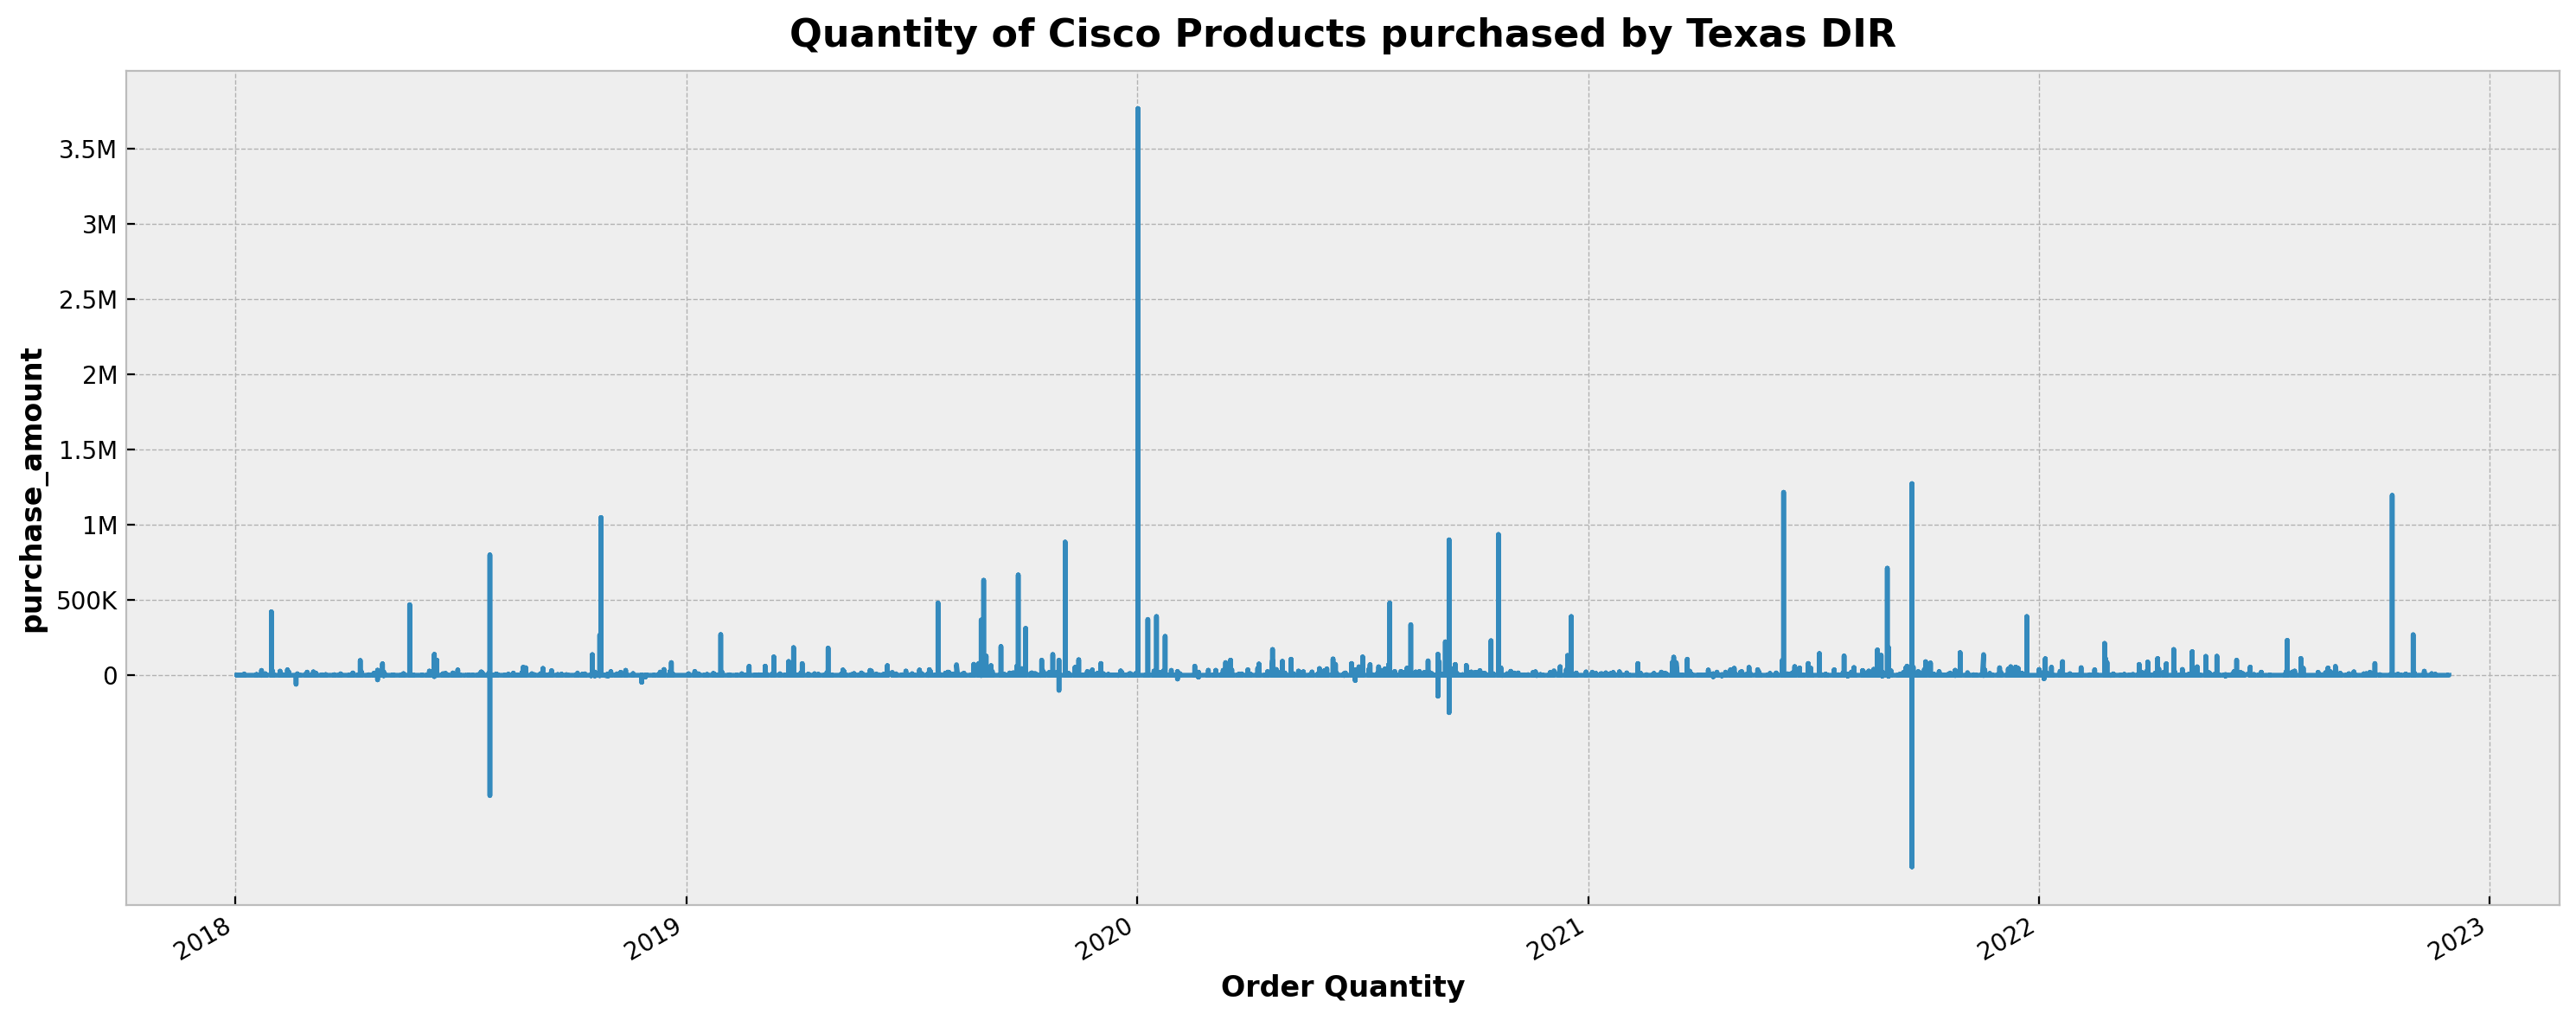

In [56]:
fix, ax = plt.subplots(figsize = (15,6))
df['order_quantity'].plot(ax=ax, xlabel='Order Quantity')
ax.set(yticks=[0, 500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000, 3_000_000, 3_500_000])
ax.set(yticklabels=['0', '500K', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M'])
ax.set(ylabel='purchase_amount') 
ax.set(title='Quantity of Cisco Products purchased by Texas DIR')

[Text(0, 0.5, 'purchase_amount')]

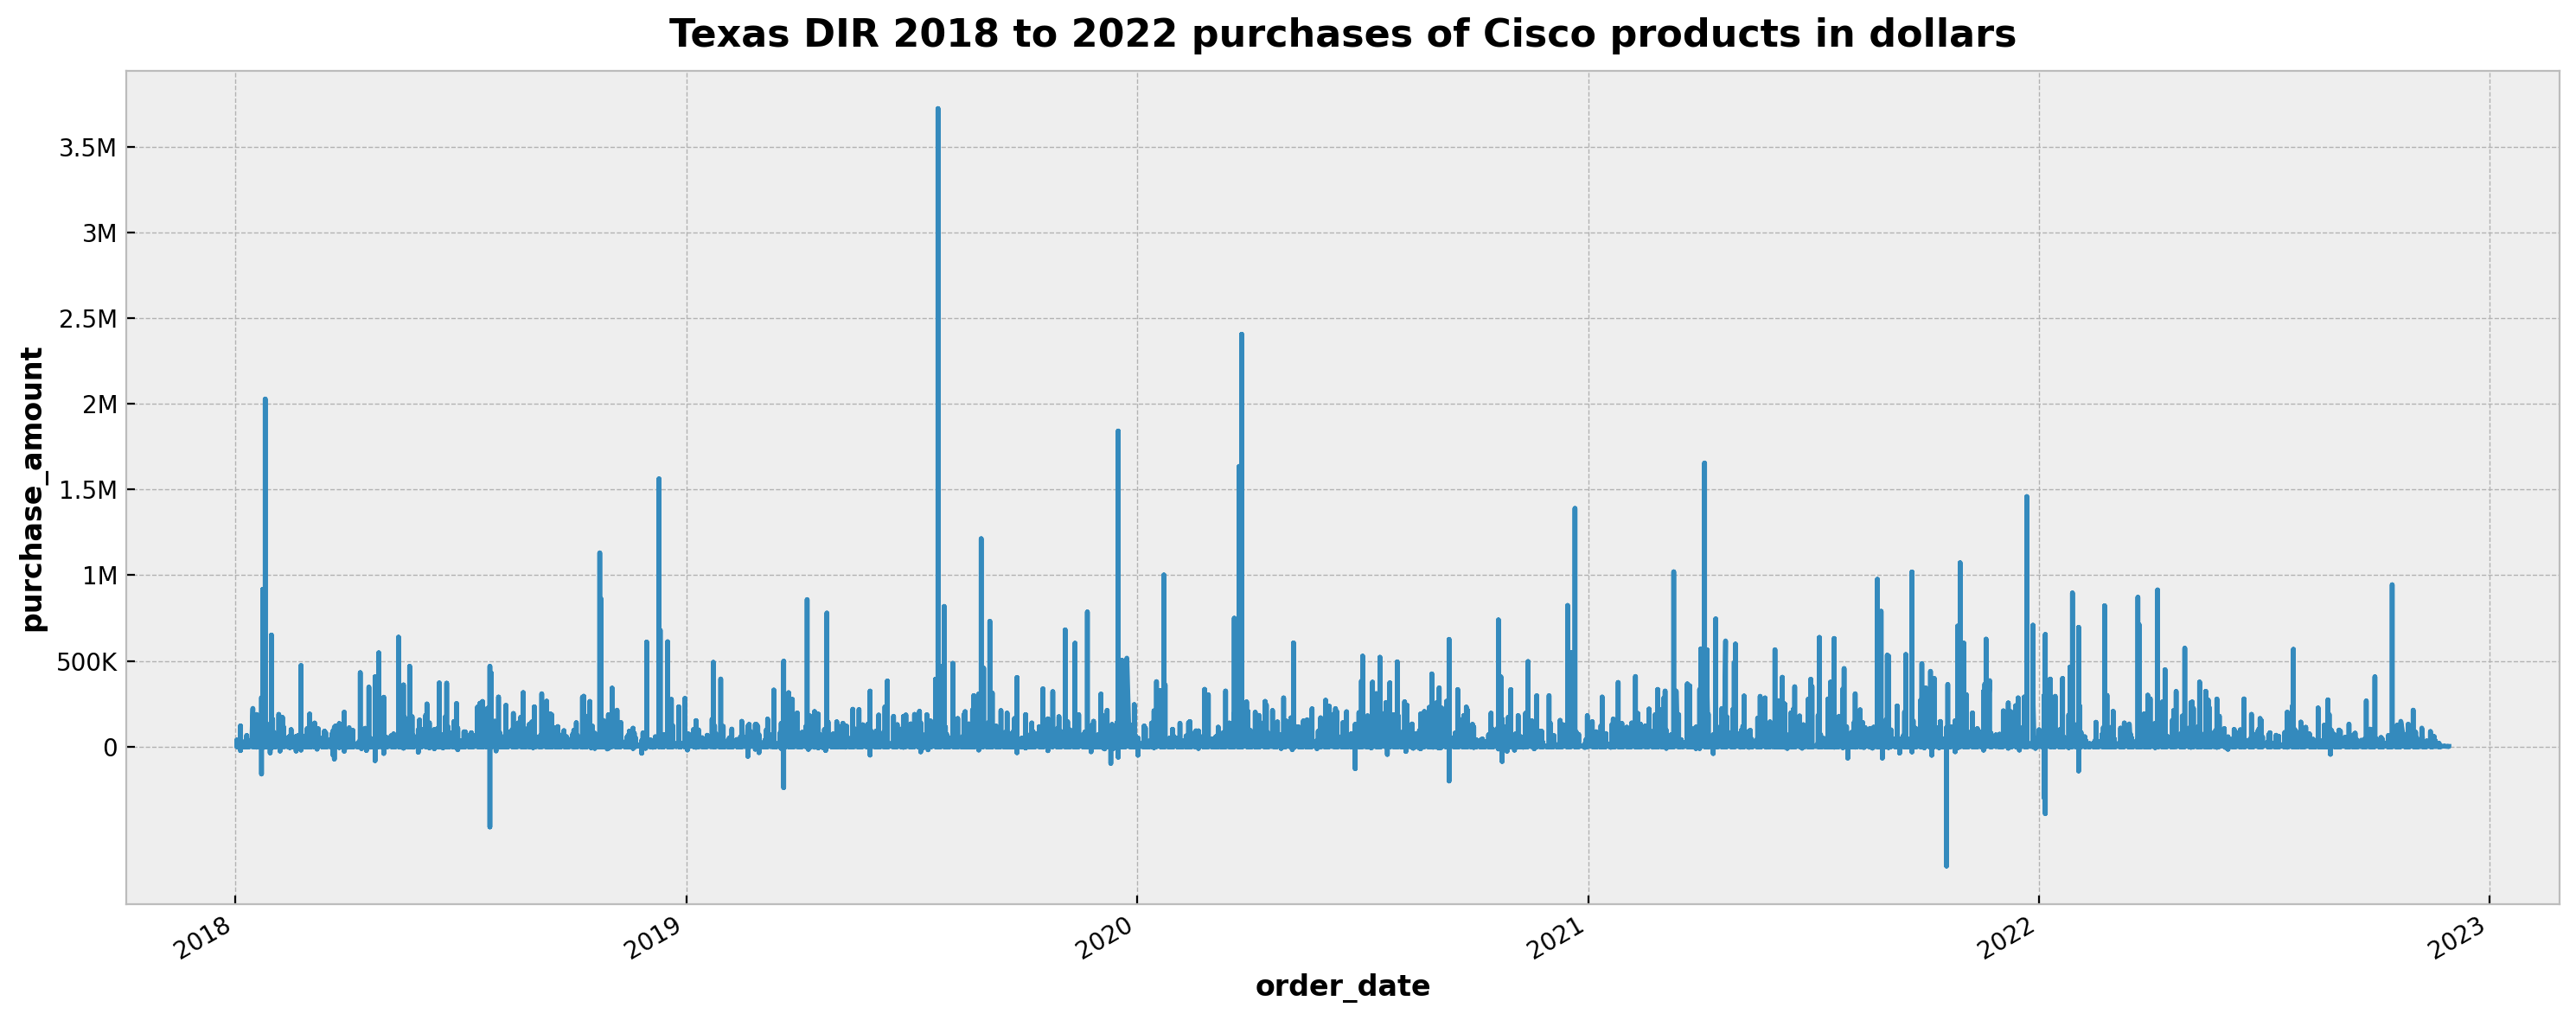

In [48]:
fix, ax = plt.subplots(figsize = (15,6))
df['purchase_amount'].plot(ax = ax, title='Texas DIR 2018 to 2022 purchases of Cisco products in dollars')
#test['purchase_amount'].plot(ax = ax, label='Test Set')
#ax.axvline('01-01-22', color='black', ls='--')

ax.set(yticks=[0, 500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000, 3_000_000, 3_500_000])
ax.set(yticklabels=['0', '500K', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M'])
ax.set(ylabel='purchase_amount') 

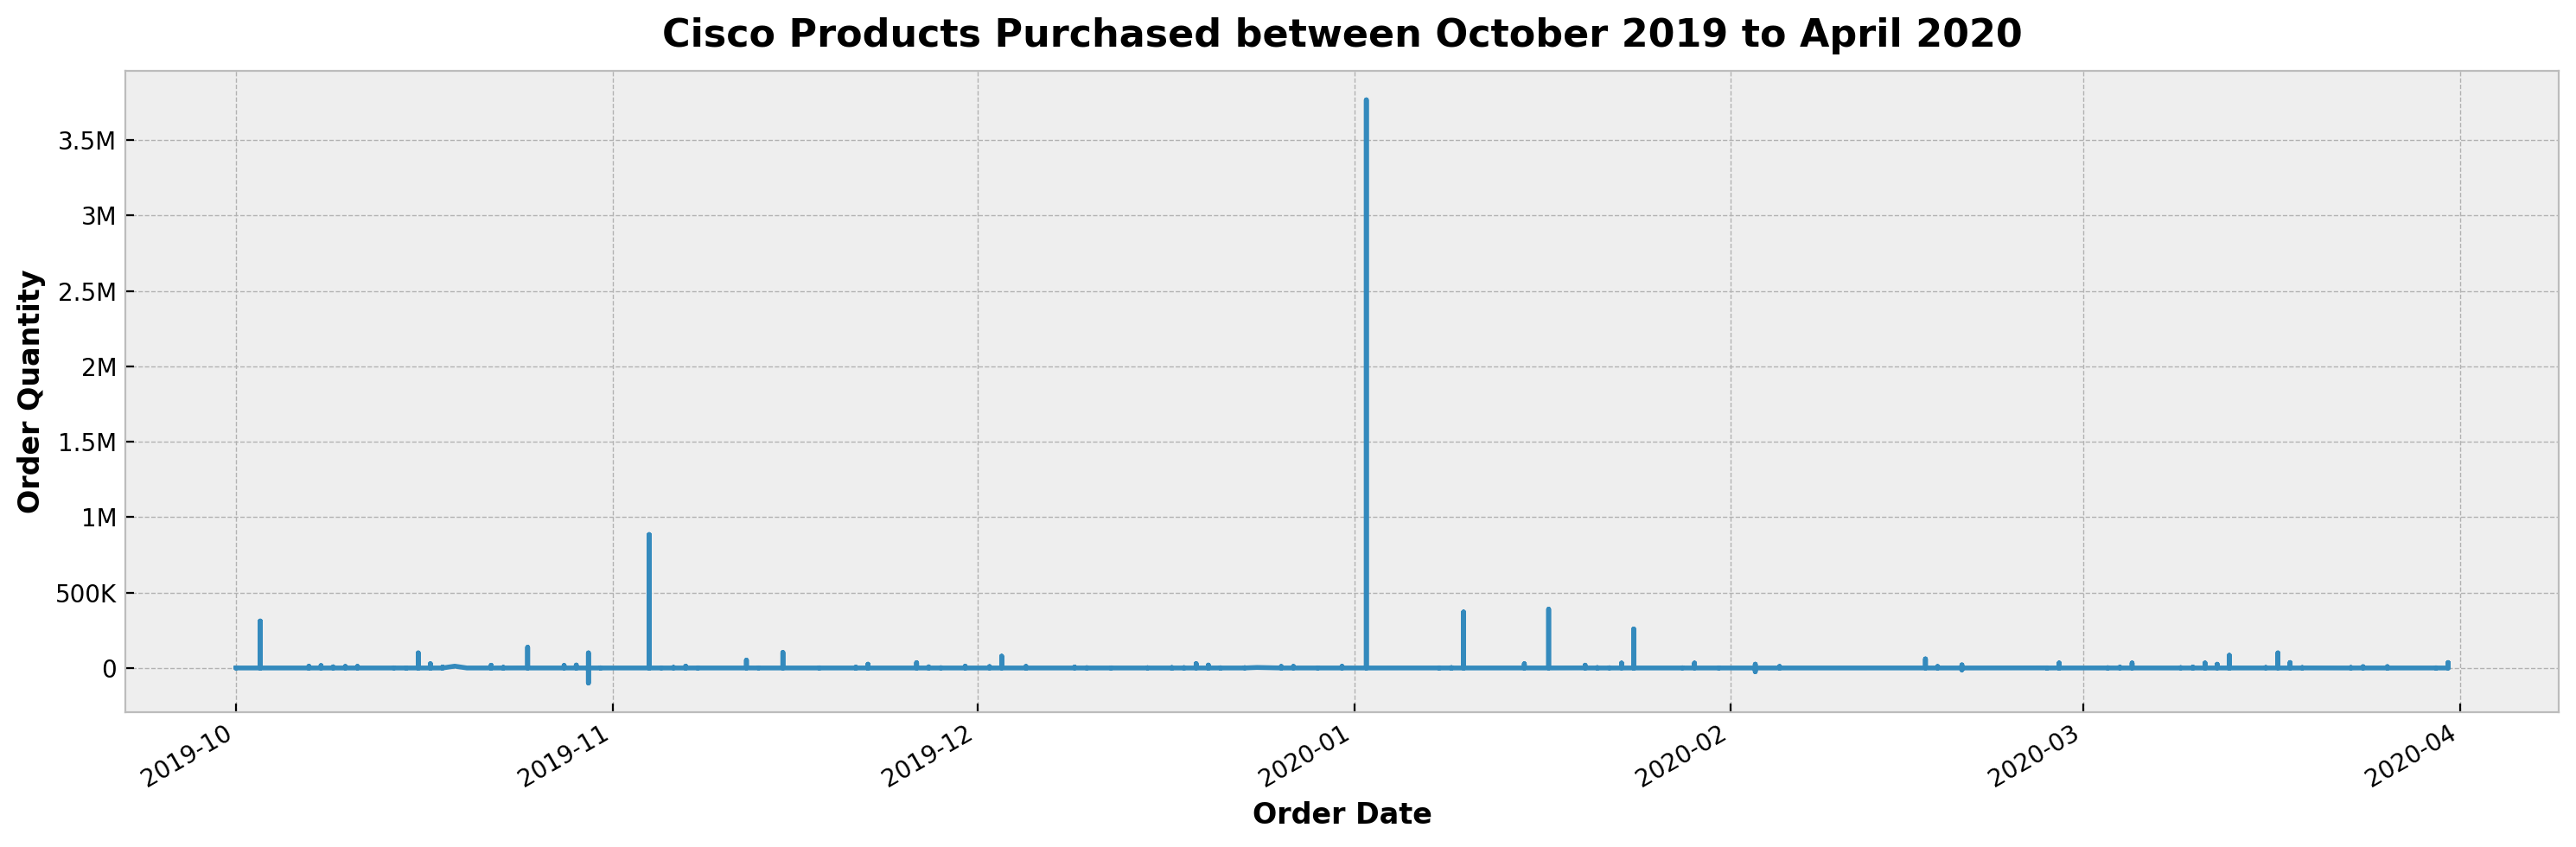

In [62]:
six_month_df = df
six_month_df = six_month_df.loc[six_month_df.index >= '10-1-2019']
six_month_df = six_month_df.loc[six_month_df.index < '04-01-2020']


fix, ax = plt.subplots(figsize = (15,5))
#ax = pandemic_df.plot(x_compat=True)-
six_month_df['order_quantity'].plot(ax=ax)
ax.set(yticks=[0, 500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000, 3_000_000, 3_500_000])
ax.set(yticklabels=['0', '500K', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M'])
ax.set(ylabel='Order Quantity') 
ax.set(xlabel = 'Order Date')
ax.set(title='Cisco Products Purchased between October 2019 to April 2020')
plt.show()